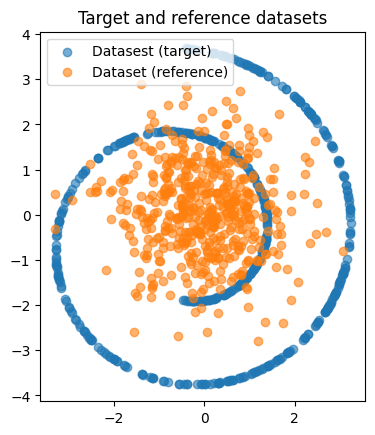

In [1]:
%load_ext autoreload
%autoreload 2

from dataset import TwoDimDataClass
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

target_ds = TwoDimDataClass(dataset_type='swiss_roll', 
                            N=1000000, 
                            batch_size=256)

prior_ds = TwoDimDataClass(dataset_type='gaussian_centered',
                           N=1000000,
                           batch_size=256)

Ntest = 500
sample_f = target_ds[0:Ntest]
sample_b = prior_ds[0:Ntest]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sample_f[:, 0], sample_f[:, 1], alpha=0.6)
ax.scatter(sample_b[:, 0], sample_b[:, 1], alpha=0.6)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')
strtitle = "Target and reference datasets"
ax.set_title(strtitle)
ax.legend(['Datasest (target)', 'Dataset (reference)'])

In [2]:
from sde import OrnsteinUhlenbeck

sde = OrnsteinUhlenbeck(N=100, T=1)

100%|█| 100/100 [00:00<00:00, 635.


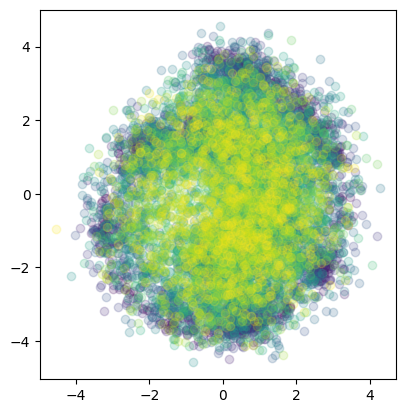

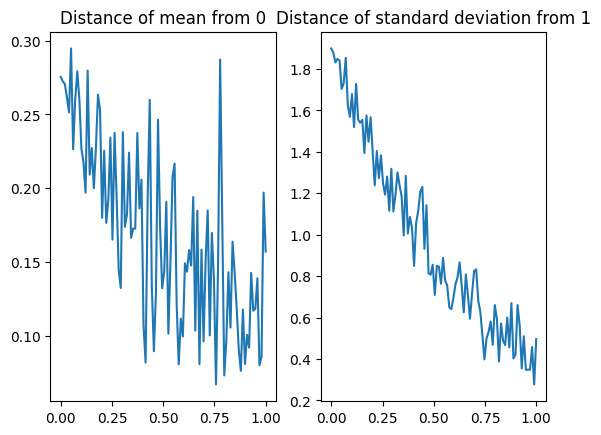

In [3]:
from tqdm import tqdm

cmap = plt.get_cmap('viridis')

n_arr = 100
plot_Ntest = 100

t_arr = np.linspace(0, sde.T, n_arr)
mean_arr = np.zeros((n_arr, 1))
std_arr = np.zeros((n_arr, 1))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for k, tt in enumerate(tqdm(t_arr)):
    x0 = target_ds[range(plot_Ntest)].float()
    t = torch.zeros((x0.shape[0],)) + tt
    mean, std = sde.marginal_prob(t, x0)
    # print(std.max())
    z = torch.randn(mean.shape)
    xt = mean + std * z

    mean_arr[k] = (xt.mean(axis=0)**2).sum()
    std_arr[k]  = ((xt.std(axis=0) - 1)**2).sum()

    ax.scatter(xt[:, 0], xt[:, 1], alpha=0.2, color=cmap(tt/t_arr[-1]))


ax.grid(False)
ax.set_aspect('equal', adjustable='box')

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
plt.plot(t_arr, np.abs(mean_arr))
plt.title("Distance of mean from 0")
ax.grid(False)
ax = fig.add_subplot(1, 2, 2)
plt.plot(t_arr, std_arr)
plt.title("Distance of standard deviation from 1")
ax.grid(False)
plt.savefig("./mean_std.jpg")

In [4]:
from network import Naive 
from torch.optim import Adam
from train_utils import get_step_fn, train_diffusion
from loss import DSMLoss

model = Naive(in_dim=2, enc_shapes=[32,32], dec_shapes=[64,64], z_dim=32)
loss_fn = DSMLoss(alpha=0.3, diff_weight=True)
optimizer = Adam(model.parameters(), lr=1e-4)
ema = None
step_fn = get_step_fn(loss_fn, optimizer, ema, sde, model)

N_steps = 15000
train_diffusion(target_ds.get_dataloader(), step_fn, N_steps)

Loss: 8.440: █| 15000/15000 [00:15


In [6]:
from sampling import Sampler

sde_backward = sde.reverse(model)
sampler = Sampler(eps=1e-3)
sampler_fn = sampler.get_sampling_fn(sde_backward, prior_ds)

plot_Ntest = 200
out, ntot, timesteps, x_hist = sampler_fn(N_samples=plot_Ntest)

sampling: 100%|█| 100/100 [00:00<0


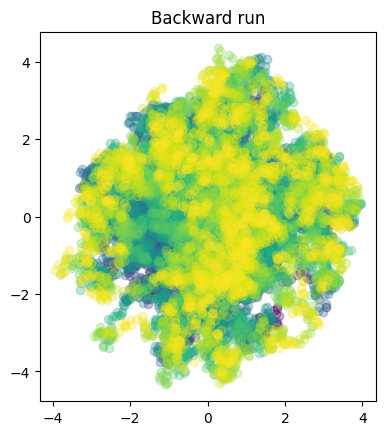

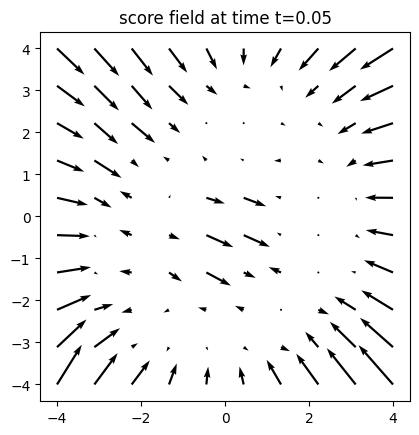

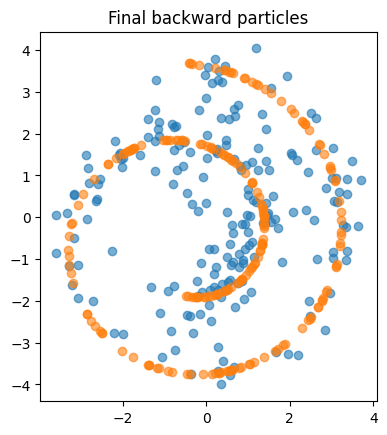

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
t_arr = np.linspace(0, sde.T, sde.N)

for k, tt in enumerate(t_arr):
    outk = x_hist[k]
    ax.scatter(outk[:, 0], outk[:, 1], alpha=0.3, color=cmap(tt/t_arr[-1]))
ax.grid(False)
ax.set_aspect('equal', adjustable='box')
strtitle = "Backward run"
ax.set_title(strtitle)
plt.savefig("./backward_run.jpg")

xmin, xmax = -4, 4
ymin, ymax = -4, 4
xx, yy = np.mgrid[xmin:xmax:10j, ymin:ymax:10j]
fig = plt.figure()
t0 = 0.05
x = np.concatenate(
    (xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=-1)
t = np.zeros((x.shape[0],)) + t0




with torch.no_grad():
    out = model(t_tensor, x_tensor)

u = out[:, 0].reshape(xx.shape)
v = out[:, 1].reshape(yy.shape)
ax = fig.add_subplot(1, 1, 1)
ax.quiver(xx, yy, u, v)
ax.set_aspect('equal', adjustable='box')
strtitle = f"score field at time t={t0}"
ax.set_title(strtitle)
plt.savefig("./score_vector_field.jpg")

out_true = target_ds[range(0, plot_Ntest)]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x_hist[-1, :, 0], x_hist[-1, :, 1], alpha=0.6)
ax.scatter(out_true[:, 0], out_true[:, 1], alpha=0.6)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')
strtitle = "Final backward particles"
ax.set_title(strtitle)
plt.savefig("./final_backward.jpg")